In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd

As the raw data downloaded from GTSRB is in zip format, the data is extracted using the <b>extract_zip_to_directory</b> function from <b>getFile.py</b>.

In [3]:
import os, sys
import glob
import cv2
import numpy as np
import pandas as pd

from PIL import Image
import shutil

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50 
from keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
train_directory = r'C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\Training'
ground_truth = r"C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\GT-final_test.csv"
test_directory = r'C:\Users\Tonmoy\Desktop\WEB\traffic_sign_recognition\GTSRB\Final_Test\Images'

In [5]:
image_paths = glob.glob(os.path.join(train_directory, '**', '*.ppm'), recursive=True)

images = []
labels = []

for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0
    images.append(image)

    label = int(image_path.split(os.sep)[-2])
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

print("Loaded", len(images), "images and", len(labels), "labels.")

Loaded 26640 images and 26640 labels.


<h2> 1.2 Simple statictics</h2>

Simple statistics of the training dataset is calculated below

In [6]:
# Get all instance of unique labels
unique_labels, label_counts = np.unique(labels, return_counts=True)
label_distribution = dict(zip(unique_labels, label_counts))

# Extract labels and counts from the label distribution dictionary
labels_list = list(label_distribution.keys())
counts = list(label_distribution.values())

# Sort labels and counts by label names
sorted_indices = np.argsort(labels_list)
labels_list = np.array(labels_list)[sorted_indices]
counts = np.array(counts)[sorted_indices]

In [7]:
# Calculate statistics
total_images = sum(counts)
average_images = total_images / len(unique_labels)
median_images = np.median(counts)
std_deviation = np.std(counts)
min_index = np.argmin(counts)
max_index = np.argmax(counts)

# Get labels for minimum and maximum values
min_label = labels_list[min_index]
max_label = labels_list[max_index]
min_images = counts[min_index]
max_images = counts[max_index]


# Print statistics
print(f"Average number of images per label: {average_images:.2f}")
print(f"Median number of images per label: {median_images}")
print(f"Standard deviation of images per label: {std_deviation:.2f}")
print(f"Minimum number of images: {min_images} for label '{min_label}'")
print(f"Maximum number of images: {max_images} for label '{max_label}'")

Average number of images per label: 619.53
Median number of images per label: 420.0
Standard deviation of images per label: 457.35
Minimum number of images: 150 for label '0'
Maximum number of images: 1500 for label '1'


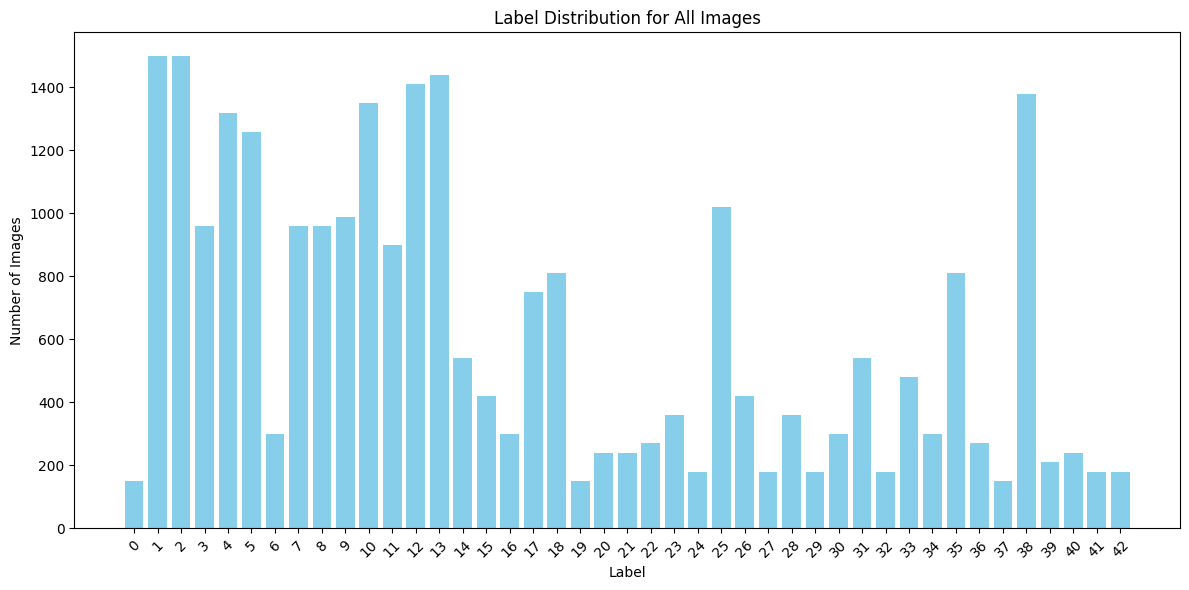

In [8]:
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels_list, counts, tick_label=labels_list, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Label Distribution for All Images')
plt.xticks(labels_list, rotation=45)
plt.tight_layout()

plt.show()

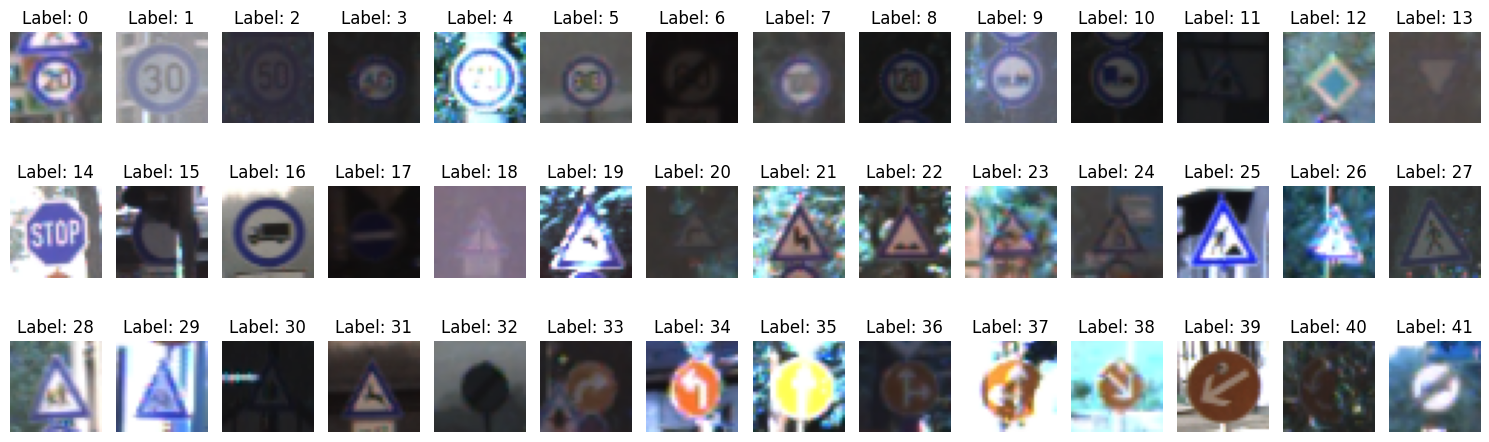

In [9]:
num_rows = 3
num_columns = 14
num_images_to_display = num_rows * num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    if i < len(np.unique(labels)):
        label = np.unique(labels)[i]
        label_indices = np.where(labels == label)[0]
        if label_indices.size > 0:
            random_index = label_indices[0]
            label_indices = label_indices[1:]

            ax.imshow(images[random_index])
            ax.set_title(f"Label: {label}")
            ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

It was realised that the traffic signs were of different shapes and sizes. However, there are signs such as **turning left and right** . Augmentation technics will thus **not be including flipping** of the images. This is due to the fact that flipping may result in a **confusion between left and right turning**.

<h2> 1.3 Data Processing </h2>

In [10]:
script_path = '../data_augmentation/processing_image.py'

script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import processing_image

 <h3>1.3.1 Ubicubic interpolation upscaling, histogram equalization and denoising</h3>

In [11]:
class_images = processing_image.convert_image_format(images)

upscale_factor = 5
upscaled_images = processing_image.upscale_images(class_images, upscale_factor)

denoised_images = processing_image.denoise_images_bilateral(upscaled_images)

equalized_images = processing_image.equalize_images_with_AHE(denoised_images)

smoothed_images = processing_image.gaussian_smoothing(equalized_images)

A visualisation of one of the images is shown below as it passes through every steps in the image enhancement pipeline. This is served as an example of the pipeline.

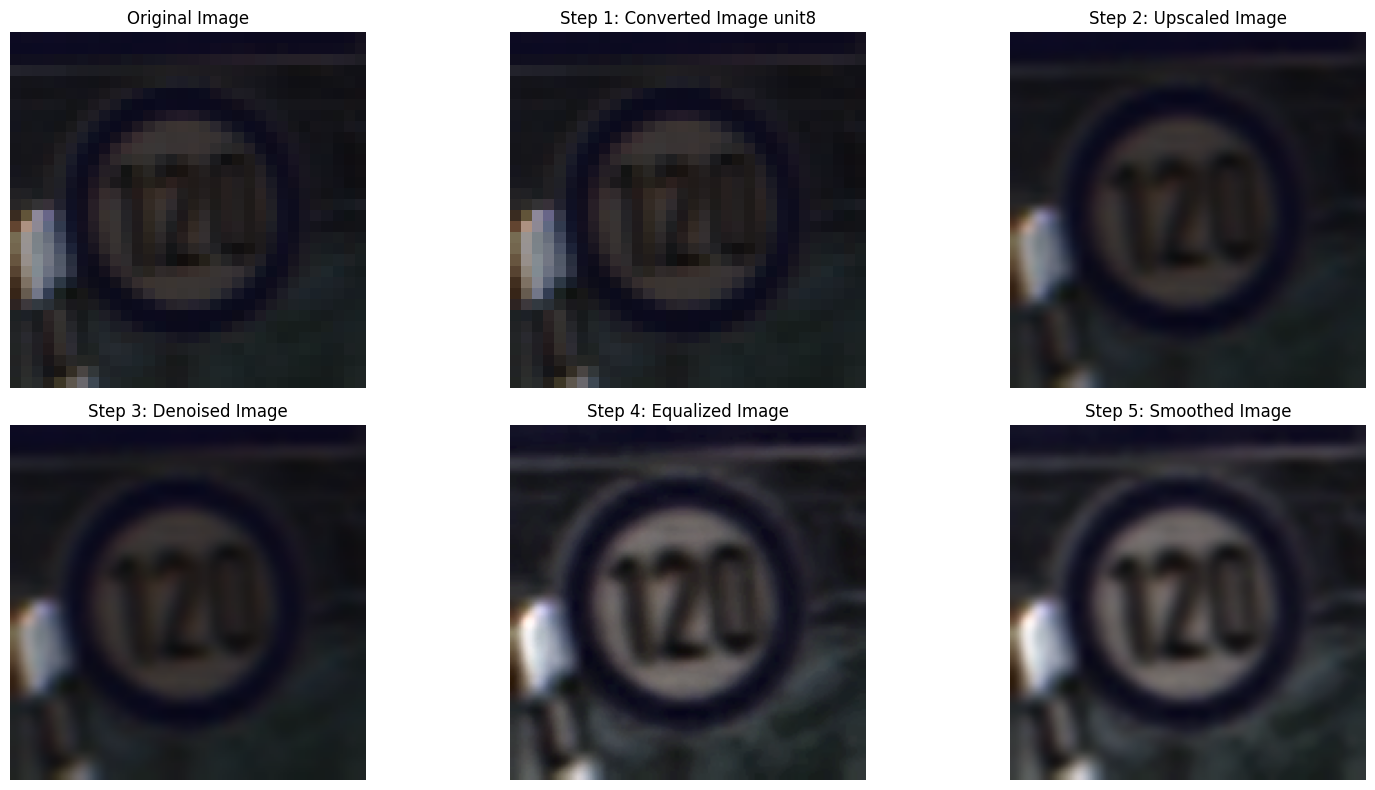

In [12]:
idx = np.random.randint(0, len(images))
plt.figure(figsize=(16, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(images[idx])
plt.title("Original Image")
plt.axis("off")

# unit8 Image
plt.subplot(2, 3, 2)
plt.imshow(class_images[idx])
plt.title("Step 1: Converted Image unit8")
plt.axis("off")

# Upscaled Image
plt.subplot(2, 3, 3)
plt.imshow(upscaled_images[idx])
plt.title("Step 2: Upscaled Image")
plt.axis("off")

# Denoised Image
plt.subplot(2, 3, 4)
plt.imshow(denoised_images[idx])
plt.title("Step 3: Denoised Image")
plt.axis("off")

# Equalized Image
plt.subplot(2, 3, 5)
plt.imshow(equalized_images[idx])
plt.title("Step 4: Equalized Image")
plt.axis("off")

# Smoothed Image
plt.subplot(2, 3, 6)
plt.imshow(smoothed_images[idx])
plt.title("Step 5: Smoothed Image")
plt.axis("off")


plt.tight_layout()
plt.show()


Based on the images above, it is obviouse that the simple enhancement technics improved the quality of the images.

The specific technics used are:


*   Upscaling: Using bicubic interpolation, the upscaled images significantly improved the resolution of the images
*   Denoising: The images were denoised using fast non-local means denoising
*   Equalization: Using adaptive histogram equalization on the Luminance channel, the lighting of the images are adjusted.
*   Smoothing: Using Gaussian smoothing, the edges of the images are smoothed



As the image quality is very perceptional and differs from person to person. Generaly, the images enhanced are seen as of a better quality as the images are less blury and pixulated. They are also of a higher resolution.

<h3>1.3.2 Data augmentation</h3>

The shape of the image array is checked below to prepare for the data augmentation.

In [13]:
smoothed_images.shape

(26640, 160, 160, 3)

It was noted from the code in the simple statistic analysis that the avaerage number of images per label is **619.53**. Thus the desired number of images per label is set to be **620.** The empty lists are created to store the augmented images and labels.

In [14]:
# Calculate the desired number of images per class
desired_images_per_class = 620

# Loop through each class
unique_labels = np.unique(labels)
augmented_images = []
augmented_labels = []

The unique_labels will be used to select the images belonging to each class. Then, the number of images needed to be augmented will be calculated by **subtracting the desired number of images per class**. It is set to 0 if the number of images is more than the desired number.

Then, the images will be augmented using the apply_augmentations function defined in the processing_image.py script. A **random image** is selected from the classes which requires augmentation **until the desired number** of images is met. The images are then appended to the augmented_images list and the labels are appended to the augmented_labels list.

In [15]:
# for recording of video and testing
# trail = smoothed_images[0:10]

In [16]:
for label in unique_labels:
    class_indices = np.where(labels == label)[0]
    class_images = smoothed_images[class_indices]

    images_needed = max(0, desired_images_per_class - class_images.shape[0])

    for _ in range(images_needed):
        # Randomly select an index from the existing images
        random_index = np.random.randint(0, class_images.shape[0])


        image_to_augment = class_images[random_index]

        # Apply augmentation techniques using OpenCV
        augmented_image = processing_image.apply_augmentations(image_to_augment)

        # Append augmented image and label to the lists
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented images and original images
final_images = np.concatenate((smoothed_images, augmented_images), axis=0)
final_labels = np.concatenate((labels, augmented_labels), axis=0)

Finally, the shape of the final_images array is shown below. It contains both original and augmented images. Each image sized **160 by 160 pixels with 3 channels**.

In [17]:
final_images.shape

(35440, 160, 160, 3)

In [18]:
final_labels.shape

(35440,)

In [19]:
unique_labels = np.unique(final_labels)


filtered_images = []
filtered_labels = []

for label in unique_labels:
    class_indices = np.where(final_labels == label)[0]

    np.random.shuffle(class_indices)
    filtered_images.extend(final_images[class_indices[:desired_images_per_class]])
    filtered_labels.extend(final_labels[class_indices[:desired_images_per_class]])

filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (26660, 160, 160, 3)
Filtered Labels Shape: (26660,)


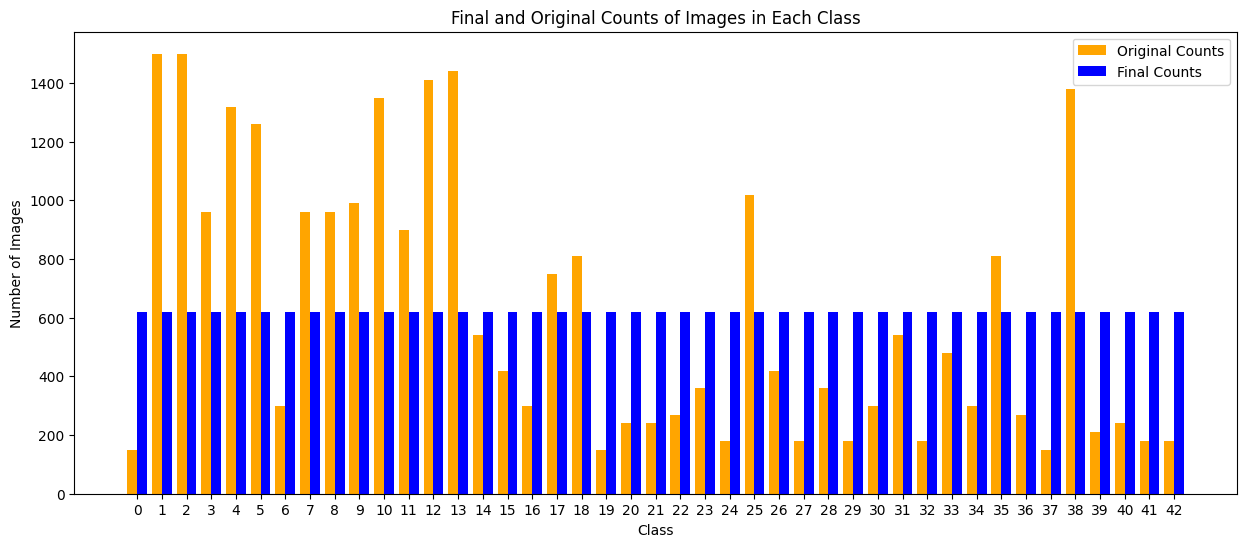

In [20]:
# Calculate the counts of images in each class for both final and original data
final_class_counts = np.bincount(filtered_labels)
original_class_counts = np.bincount(labels)

# Number of classes
num_classes = len(final_class_counts)

# Create an array of class labels
class_labels = np.arange(num_classes)

# Calculate the bar width and the gap between original and final counts
bar_width = 0.4
gap = 0.2

# Calculate the positions for the bars
original_bar_positions = class_labels * (2 * bar_width + gap) - bar_width / 2
final_bar_positions = class_labels * (2 * bar_width + gap) + bar_width / 2

# Plot the graph
plt.figure(figsize=(15, 6))

# Plot original counts in orange
plt.bar(original_bar_positions, original_class_counts, color='orange', width=bar_width, label='Original Counts')

# Plot final counts in blue
plt.bar(final_bar_positions, final_class_counts, color='blue', width=bar_width, label='Final Counts')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Final and Original Counts of Images in Each Class')
plt.xticks(class_labels * (2 * bar_width + gap), class_labels)  # Adjust xticks positions
plt.legend()
plt.show()


As the training of the model will be done on another instance of collab with GPU, the images will be saved in the Google drive.

Firstly, the files and folder were saved to local instance of colab. A dataframe is created to store the images name and labels.

In [21]:
# Define the folder path to save the images
save_folder = "augmented_images"
os.makedirs(save_folder, exist_ok=True)

# Save augmented images to the folder
for i, image in enumerate(filtered_images):

    class_label = filtered_labels[i]

    filename = f"{class_label}_{i}.png"
    file_path = os.path.join(save_folder, filename)
    cv2.imwrite(file_path, image)

# Create a list of dictionaries for DataFrame
data = []
for i in range(len(filtered_images)):

    class_label = filtered_labels[i]

    filename = f"{class_label}_{i}.png"
    data.append({"class": class_label, "filename": filename})

# Create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)

print("Images saved and DataFrame created.")

Images saved and DataFrame created.


The size of the images files stored in the local colab instance is checked below. It should be the same as the size of the final images.

In [22]:
# Specify the directory path
folder_path = 'augmented_images'

# List all files in the directory
file_list = os.listdir(folder_path)

# Count the number of files
num_files = len(file_list)

print(f"Number of files in the folder: {num_files}")

df.to_csv("augmented_images.csv", index=False)

Number of files in the folder: 26660
